# Affinity vs concentration footprinting

For KLF, OCTSOX and maybe some other motifs, perform footprinting for different affinity buckets and difference cell states.

In [115]:
import modisco
import h5py
import deepdish
import intervaltree
from collections import defaultdict, OrderedDict, Counter
from modisco.visualization import viz_sequence
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

from matplotlib import pyplot as plt
import numpy as np
import tqdm
import modisco
from modisco.visualization import viz_sequence
import tqdm
import pyBigWig
import pyfaidx
from math import ceil

In [4]:
import keras
from keras.utils import CustomObjectScope

import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils import shap_utils
import shap
from pathlib import Path
import pandas as pd

In [5]:
!pip freeze | grep modisco

modisco==0.5.15.0


In [6]:
import os

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [8]:
def revcomp(x):
    # Assuming ACGT
    return x[::-1][:,::-1]

## Load Config

In [9]:
config = pd.read_csv("../configs/cluster.tsv", sep='\t')
config

cluster   colour             description  new_cluster
0         1  #B03743              Fibroblast            1
1         2  #E85F6D         Fibroblast-like            3
2         3  #7C2730         Fibroblast-like            2
3         4  #F0A118            Intermediate           12
4         5  #78A824                Pre-iPSC           13
5         6  #A6D854                Pre-iPSC           14
6         7  #F01D35         Fibroblast-like            5
7         8  #13C4A3                    iPSC           15
8         9  #406614  Partially-reprogrammed           10
9        10  #D4B81C            Intermediate            9
10       11  #006658                    xOSK            8
11       12  #CF175A         Fibroblast-like            4
12       13  #F7A6C2       Keratinocyte-like            6
13       14  #F4D5CD            Intermediate           11
14       15  #F0520A                    hOSK            7

## Load Models

In [10]:
CELL_STATES = list(range(1,16))

In [11]:
MODEL_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/"

In [12]:
# load models
bias_models = dict()
models = dict()
with CustomObjectScope({'multinomial_nll': multinomial_nll}):
    for x in CELL_STATES:
        model_paths = list(Path(MODEL_BASE).glob("cluster_idx{}/*.h5".format(x)))
        assert(len(model_paths)==2)
        
        bias_model_path = str([x for x in model_paths if "adjusted" in str(x)][0])
        model_path = str([x for x in model_paths if "adjusted" not in str(x)][0])
        print(bias_model_path)
        print(model_path)
        models[x] = keras.models.load_model(model_path)
        bias_models[x] = keras.models.load_model(bias_model_path)

/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/IkhV3.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/IkhV3.h5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx2/pAQpM.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx2/pAQpM.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx3/jq0be.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx3/jq0be.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/b

In [13]:
profile_explainers = dict()

for x in CELL_STATES:
    weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(models[x])
    profile_explainers[x] = shap.explainers.deep.TFDeepExplainer(
        ([models[x].input[0], models[x].input[1]], weightedsum_meannormed_logits),
        shap_utils.shuffle_several_times,
        combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

In [14]:
MODEL_INP_LEN = models[CELL_STATES[0]].input_shape[0][1]
MODEL_INP_LEN

2000

In [15]:
MODEL_OUT_LEN = models[CELL_STATES[0]].output_shape[0][1]
MODEL_OUT_LEN

2000

In [16]:
assert(MODEL_INP_LEN==bias_models[CELL_STATES[0]].input_shape[1])

### Get sequences of negative regions for each cell state

In [17]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)

In [18]:
NEG_REGION_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/gc_neg/cluster_idx{}.gc.neg.bed"

In [19]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [20]:
SUBSAMPLE = 5000
gc_neg_per_state = dict()
for x in CELL_STATES:
    cur_gc_neg_peaks_df =  pd.read_csv(NEG_REGION_BASE.format(x),
                                       sep='\t',
                                       names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"])
    
    cur_gc_neg_peaks_df = cur_gc_neg_peaks_df.sample(SUBSAMPLE)
    
    gc_neg_per_state[x] = get_seq(hg38, cur_gc_neg_peaks_df, MODEL_INP_LEN)

### Motif list

In [6]:
motifs = pd.read_csv("/users/surag/kundajelab/scATAC-reprog/src/analysis/20211007_motif_consolidation/20210820_chrombpnet_lite/tfs_final_w_rep.tsv", 
            sep='\t',
           names=['gimme_name', 'tomtom_name', 'representative', 'short_name'])
motifs['rep_clst'] = motifs['representative'].transform(lambda x: int(x.split("_")[0].strip("cts")))
motifs['rep_pattern'] = motifs['representative'].transform(lambda x: '_'.join(x.split("_")[1:]))
motifs

gimme_name            tomtom_name   representative short_name  \
0           Average_149          REST_MA0138.2   cts6_pattern_8       REST   
1           Average_143          CTCF_MA0139.1   cts8_pattern_0       CTCF   
2           Average_138  ZN143_MOUSE.H11MO.0.A  cts9_pattern_13     ZNF143   
3           Average_182   NFYB_HUMAN.H11MO.0.A   cts9_pattern_7        NFY   
4           Average_136   SIX1_HUMAN.H11MO.0.A   cts8_pattern_6        SIX   
5           Average_220          IRF1_MA0050.2  cts1_pattern_12        IRF   
6   cts7_pattern_11.pfm  MEF2D_MOUSE.H11MO.0.A  cts7_pattern_11       MEF2   
7           Average_225  PO5F1_MOUSE.H11MO.0.A  cts11_pattern_0    OCT-SOX   
8   cts8_pattern_11.pfm            TEAD1_TEA_2  cts8_pattern_11  TEAD-TEAD   
9           Average_224   NFIC_HUMAN.H11MO.0.A  cts10_pattern_4        NFI   
10          Average_230         CEBPA_MA0102.3   cts2_pattern_9       CEBP   
11          Average_228  FOSL2_HUMAN.H11MO.0.A  cts12_pattern_0        AP1   
12          Average_117   RFX2_MOUSE.H11MO.0.A   cts8_pattern_9        RFX   
13          Average_175   NRF1_HUMAN.H11MO.0.A   cts9_pattern_9        NRF   
14          Average_158  RUNX3_HUMAN.H11MO.0.A   cts7_pattern_3       RUNX   
15  cts8_pattern_17.pfm            GRHL1_CP2_1  cts8_pattern_17       GRHL   
16   cts8_pattern_4.pfm   ZIC3_HUMAN.H11MO.0.B   cts8_pattern_4        ZIC   
17          Average_234  TEAD4_HUMAN.H11MO.0.A   cts8_pattern_3       TEAD   
18          Average_213   ETS1_MOUSE.H11MO.0.A   cts9_pattern_4        ETS   
19          Average_223   ATF2_HUMAN.H11MO.0.B   cts1_pattern_5       CREB   
20          Average_231  TWST1_MOUSE.H11MO.0.B   cts7_pattern_2       BHLH   
21          Average_177         FOXC2_MA0846.1   cts2_pattern_2        FOX   
22          Average_191  NFKB1_HUMAN.H11MO.1.B   cts7_pattern_9       NFKB   
23          Average_145   AP2A_MOUSE.H11MO.0.A   cts6_pattern_3      TFAP2   
24   cts8_pattern_8.pfm        POU3F2_MA0787.1   cts8_pattern_8        OCT   
25   cts7_pattern_5.pfm   EGR2_MOUSE.H11MO.0.A   cts7_pattern_5        EGR   
26  cts9_pattern_19.pfm   COE1_HUMAN.H11MO.0.A  cts9_pattern_19        COE   
27  cts11_pattern_4.pfm         SOX15_MA1152.1  cts11_pattern_4        SOX   
28   cts1_pattern_6.pfm    SP2_HUMAN.H11MO.0.A   cts1_pattern_6         SP   
29  cts11_pattern_1.pfm   KLF3_HUMAN.H11MO.0.B  cts11_pattern_1        KLF   

    rep_clst rep_pattern  
0          6   pattern_8  
1          8   pattern_0  
2          9  pattern_13  
3          9   pattern_7  
4          8   pattern_6  
5          1  pattern_12  
6          7  pattern_11  
7         11   pattern_0  
8          8  pattern_11  
9         10   pattern_4  
10         2   pattern_9  
11        12   pattern_0  
12         8   pattern_9  
13         9   pattern_9  
14         7   pattern_3  
15         8  pattern_17  
16         8   pattern_4  
17         8   pattern_3  
18         9   pattern_4  
19         1   pattern_5  
20         7   pattern_2  
21         2   pattern_2  
22         7   pattern_9  
23         6   pattern_3  
24         8   pattern_8  
25         7   pattern_5  
26         9  pattern_19  
27        11   pattern_4  
28         1   pattern_6  
29        11   pattern_1

## Load Motif Data

In [22]:
Counter(motifs['rep_clst']).most_common()

[(8, 8), (9, 5), (7, 5), (1, 3), (11, 3), (6, 2), (2, 2), (10, 1), (12, 1)]

In [23]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called]
MODISCO_CROP_WIDTH = 500

In [24]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [25]:
def get_regions(regions_file, crop_width):
    with open(regions_file) as f:
        scored_regions = [x.strip().split('\t') for x in f]

    # importance scores are computed centered at summit (2nd col + 10th col)
    scored_regions = [(x[0], int(x[9])+int(x[1])-crop_width//2, int(x[9])+int(x[1])+crop_width//2) for x in scored_regions]
    
    return scored_regions

In [26]:
def fetch_data(modisco_hdf5, pattern_name, pattern_start, pattern_end,
               regions, modisco_crop_width, genome, 
               rc_everything=False, imp_width =2114, expand_bw=100):
    """
    this function basically goes through the seqlets of a given pattern (pattern_name)
    it pulls out raw shap scores for each seqlet, its coordinates, whether it's RC-ed,
    its subcluster indices
    
    returned seqlets all have the same orientation!
    pattern_start -> start of pattern within seqlet ([0,seqlen_len)]
    pattern_end-> start of pattern within seqlen ((pattern_start,seqlen_len)]
    """
    
    # region sliced out and used for modisco
    imp_crop_start = imp_width//2 - modisco_crop_width//2
    imp_crop_end = imp_width//2 + modisco_crop_width//2
    
    pattern = modisco_hdf5['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][pattern_name]
    
    seqlet_len = pattern["sequence"]["fwd"].shape[0]
    
    subcluster_idxs = np.array(list(pattern["subclusters"]))
    
    seqlet_coords = []
    seqlet_is_rc = []
    seqlet_shaps = []
    seqlet_one_hots = []
    
    # fetch info from the bigwigs where the seqlets are present
    for i in tqdm.trange(len(pattern['seqlets_and_alnmts']['seqlets'])):
        x = pattern['seqlets_and_alnmts']['seqlets'][i]
        
        # index into regions/imp_scores, i.e. which entry in regions does each seqlet come from
        idx = int(x.decode('utf8').split(',')[0].split(':')[1])
        start = int(x.decode('utf8').split(',')[1].split(':')[1])
        rc = eval(x.decode('utf8').split(',')[3].split(':')[1])

        reg = regions[idx]

        seqlet_is_rc.append(rc)
        
        if rc:
            start_coord = reg[1]+start+(seqlet_len-pattern_end)
            end_coord = reg[1]+start+(seqlet_len-pattern_start)
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            seqlet_one_hots.append(revcomp(one_hot.dna_to_one_hot([str(genome[reg[0]][start_coord:end_coord])])[0]))
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw            
            
        else:            
            start_coord = reg[1]+start+pattern_start
            end_coord = reg[1]+start+pattern_end
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            seqlet_one_hots.append(one_hot.dna_to_one_hot([str(genome[reg[0]][start_coord:end_coord])])[0])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw                    
        
    # RC-ing all instances
    seqlet_shaps = np.array(seqlet_shaps) #[:,::-1,::-1]
    seqlet_one_hots = np.array(seqlet_one_hots)  # [:,::-1,::-1]
    
    if rc_everything:
        seqlet_shaps = seqlet_shaps[:, ::-1, ::-1]
        seqlet_one_hots = seqlet_one_hots[:, ::-1, ::-1]
    
    return seqlet_coords, seqlet_is_rc, subcluster_idxs, seqlet_one_hots

### Extract motifs

In [27]:
motifs_one_hots = {}

for ctype in set(motifs['rep_clst']):
    motifs_subset = motifs[motifs['rep_clst']==ctype]
    
    modisco_path = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx{}/modisco/modisco_results_allChroms_counts.hdf5".format(ctype)
    regions_path = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx{}/interpret/interpreted_regions.bed".format(ctype)
    
    modisco = h5py.File(modisco_path, 'r')
    regions = get_regions(regions_path, MODISCO_CROP_WIDTH)
    
    for _, x in motifs_subset.iterrows():
        _, _, _, one_hots = \
            fetch_data(modisco, x['rep_pattern'], 0, 30,
                   regions, 
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

        motifs_one_hots[x['tomtom_name']] = one_hots.copy()
    
    modisco.close()

100%|██████████| 5989/5989 [00:04<00:00, 1335.90it/s]


### Trim motifs

In [28]:
def trim_ppm(ppm, t=0.45, min_length=3, flank=2):
    # trim matrix to first and last bp that have
    # p>=threshold 
    maxes = np.max(ppm,-1)
    maxes = np.where(maxes>=t)

    # if no bases with prob>t or too small:
    if (len(maxes[0])==0) or (maxes[0][-1]+1-maxes[0][0]<min_length):
        return None
    
    return max(maxes[0][0]-flank, 0), maxes[0][-1]+1+flank

In [29]:
trimmed_one_hots = {}
for x in motifs_one_hots:
    start, end = trim_ppm(motifs_one_hots[x].mean(0))
    trimmed_one_hots[x] = motifs_one_hots[x][:, start:end]

### Computing log-odds scores

IRF1_MA0050.2


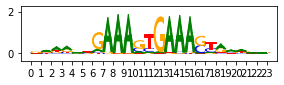

ATF2_HUMAN.H11MO.0.B


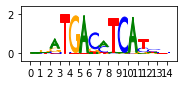

SP2_HUMAN.H11MO.0.A


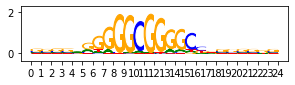

CEBPA_MA0102.3


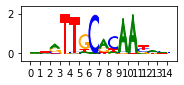

FOXC2_MA0846.1


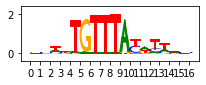

REST_MA0138.2


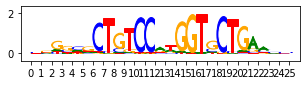

AP2A_MOUSE.H11MO.0.A


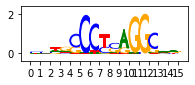

MEF2D_MOUSE.H11MO.0.A


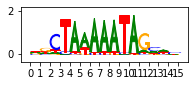

RUNX3_HUMAN.H11MO.0.A


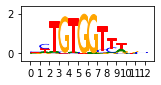

TWST1_MOUSE.H11MO.0.B


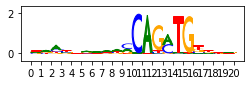

NFKB1_HUMAN.H11MO.1.B


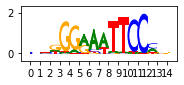

EGR2_MOUSE.H11MO.0.A


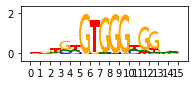

CTCF_MA0139.1


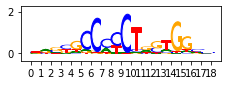

SIX1_HUMAN.H11MO.0.A


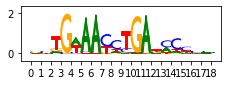

TEAD1_TEA_2


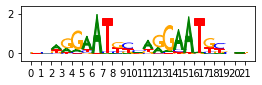

RFX2_MOUSE.H11MO.0.A


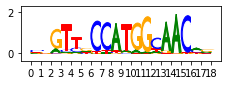

GRHL1_CP2_1


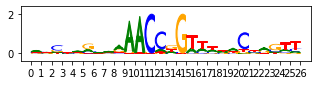

ZIC3_HUMAN.H11MO.0.B


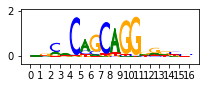

TEAD4_HUMAN.H11MO.0.A


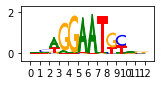

POU3F2_MA0787.1


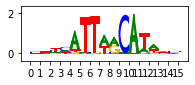

ZN143_MOUSE.H11MO.0.A


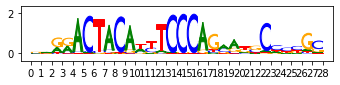

NFYB_HUMAN.H11MO.0.A


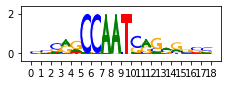

NRF1_HUMAN.H11MO.0.A


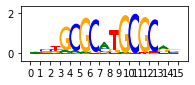

ETS1_MOUSE.H11MO.0.A


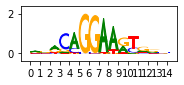

COE1_HUMAN.H11MO.0.A


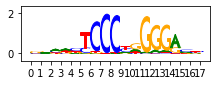

NFIC_HUMAN.H11MO.0.A


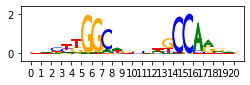

PO5F1_MOUSE.H11MO.0.A


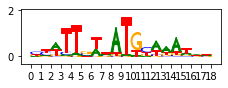

SOX15_MA1152.1


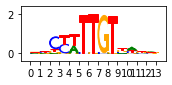

KLF3_HUMAN.H11MO.0.B


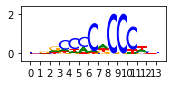

FOSL2_HUMAN.H11MO.0.A


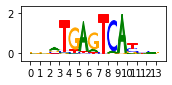

In [30]:
for x in trimmed_one_hots:
    print(x)
    viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed_one_hots[x].mean(0), background=[0.25]*4), 
                              figsize=(6*trimmed_one_hots[x].shape[1]/30,1))

In [31]:
from random import sample, randint, shuffle

In [32]:
logodds_mats = {}
logodds_scores = {}

for x in trimmed_one_hots:
    logodds_mats[x] = np.log((trimmed_one_hots[x].mean(0) + 1e-10)/0.25)
    logodds_scores[x] = np.sum(trimmed_one_hots[x]*logodds_mats[x], axis=(1,2))

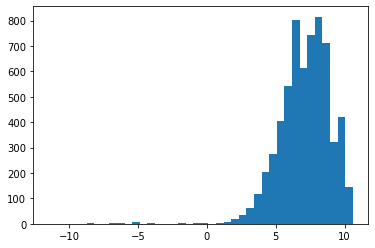

In [33]:
plt.hist(logodds_scores['KLF3_HUMAN.H11MO.0.B'], bins=40)
plt.show()

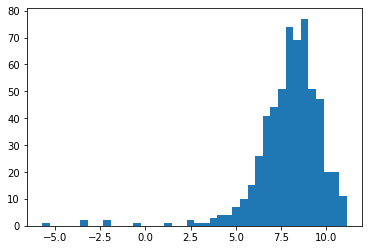

In [34]:
plt.hist(logodds_scores['SOX15_MA1152.1'], bins=40)
plt.show()

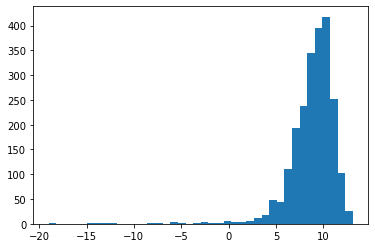

In [35]:
plt.hist(logodds_scores['AP2A_MOUSE.H11MO.0.A'], bins=40)
plt.show()

In [151]:
for x in trimmed_one_hots:
    with open("./Supp/virtual_footprints/motifs/{}.tsv".format(x.split("_")[0]), 'w') as f:
        for y in trimmed_one_hots[x].mean(0):
            f.write("\t".join([str(v) for v in y]) + "\n")

## Virtual Footprinting

Insert motifs of different affinities in negative regions for each model and visualize footprints.

In [37]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [38]:
def profiles_for_motif(model, model_bias, seqs, motifs_one_hot, rep_motifs=5):
    # rep motifs multiple times
    motifs_one_hot_rep = np.tile(motifs_one_hot, (rep_motifs, 1, 1))
    
    # choose one background for each motif
    idxs = np.random.choice(range(seqs.shape[0]), motifs_one_hot_rep.shape[0], replace=True)
    
    seqs_selected = seqs[idxs]
    w_mot_seqs = seqs_selected.copy()
    MID = MODEL_INP_LEN//2 - motifs_one_hot.shape[1]//2
    
    w_mot_seqs[:, MID:MID+motifs_one_hot.shape[1]] = motifs_one_hot_rep

#     raw_seqs_pred_bias, raw_seqs_pred_cts = model_bias.predict(seqs_selected, verbose=True)
    w_mot_seqs_pred_bias, w_mot_seqs_pred_cts = model_bias.predict(w_mot_seqs, verbose=True)
    
    
    
#     wo_mot_pred_w_bias, wo_mot_pred_w_bias_cts = model.predict([seqs_selected, 
#                                                                 raw_seqs_pred_bias,
#                                                                 raw_seqs_pred_cts], 
#                                                                verbose=True)

    w_mot_pred_unplug_bias, _ = model.predict([w_mot_seqs, 
                                               np.zeros((w_mot_seqs_pred_bias.shape[0],MODEL_OUT_LEN)), 
                                                     np.zeros((w_mot_seqs_pred_bias.shape[0],1))],
                                              verbose=True)
#     w_mot_pred_w_bias, w_mot_pred_w_bias_cts = model.predict([w_mot_seqs, 
#                                                               w_mot_seqs_pred_bias,
#                                                               w_mot_seqs_pred_cts], 
#                                                              verbose=True)
    
    return(softmax(w_mot_pred_unplug_bias + w_mot_seqs_pred_bias), softmax(w_mot_pred_unplug_bias))

In [39]:
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, start=950, end=1060):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_w_bias[:, start:end].mean(0), label='uncorrected')
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0), label='corrected')
    plt.plot(range(width), pred_wo_motif_w_bias[:, start:end].mean(0), '--', label='uncorrected w/o motif')
    plt.legend()
    plt.show()

    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

In [40]:
# raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts = \
#   profiles_for_motif(models[5], bias_models[5], gc_neg_per_state[5], KLF_one_hots[KLF_log_odd_scores>9],
#                     rep_motifs=2)

In [41]:
# aff_quants10 = [0.1*x for x in range(1,11)] # includes max
aff_quants3 = [0.1,.4,.7,1]

# print(aff_quants10)
print(aff_quants3)

[0.1, 0.4, 0.7, 1]


In [42]:
def make_footprint_grid(one_hots, log_odds_scores, aff_quants, cell_states, profile_sample=100, min_seq_per_element=1000):
    # aff_vals should look something like [v1,v2...vn,vmax] <-- max quant (likely 1) at the end!!
    # takes motifs in each v_i v_{i+1}
    
    aff_vals = np.quantile(log_odds_scores, aff_quants)
    
    assert(list(aff_vals) == sorted(list(aff_vals)))
    
    aff_dict = OrderedDict()
    for i in range(len(aff_vals)-1):
        aff_dict[i] = one_hots[(log_odds_scores>aff_vals[i])&(log_odds_scores<=aff_vals[i+1])]
    
    cell_state_fp_w_bias = defaultdict(dict)
    cell_state_fp_debias = defaultdict(dict)

    for x in cell_states:
        for aff in aff_dict:
            raw_footprint, debiased_footprint = profiles_for_motif(models[x], 
                                                                   bias_models[x],
                                                                   gc_neg_per_state[x],
                                                                   aff_dict[aff], 
                                                                   rep_motifs=ceil(min_seq_per_element/aff_dict[aff].shape[0]))

            cell_state_fp_w_bias[x][aff] = raw_footprint.mean(0)
            cell_state_fp_debias[x][aff] = debiased_footprint.mean(0)
                    
    
    return cell_state_fp_w_bias, cell_state_fp_debias 

In [ ]:
len(footprint_data['IRF1_MA0050.2'][0][1][0])

In [55]:
plt.Subplot

matplotlib.axes._subplots.AxesSubplot

In [94]:
# def plot_footprints_grid_old(w_bias, wo_bias, log_odds_scores, aff_quants, title, width=100, rev_y = False, add_w_bias=False):
    
#     aff_vals = np.quantile(log_odds_scores, aff_quants)
    
#     cell_states = list(wo_bias.keys())
#     affs = list(wo_bias[cell_states[0]].keys())
    
#     fig, axs = plt.subplots(len(affs), len(cell_states), figsize=(3*len(cell_states),4*len(affs)), sharey=True)

#     start = len(wo_bias[cell_states[0]][affs[0]])//2-width//2
#     end = len(wo_bias[cell_states[0]][affs[0]])//2+width//2
    
#     for cidx,cs in enumerate(wo_bias):        
#         for aidx,aff in enumerate(wo_bias[cs]):
#             y_idx = aidx if not rev_y else len(affs)-aidx-1
                            
#             if add_w_bias:
#                 axs[y_idx][cidx].plot(range(-width//2, width//2), w_bias[cs][aff][start:end], 'r--', linewidth=0.5)
            
#             axs[y_idx][cidx].plot(range(-width//2,width//2), wo_bias[cs][aff][start:end], 
#                            c='k')
# #                            c= config.iloc[cs-1]['colour'])

#     for ax, col in zip(axs[0], cell_states):
#         ax.set_title("{}".format(config.iloc[col-1]["new_cluster"]))
# #         ax.set_title("{} - {}".format(config.iloc[col-1]["new_cluster"], 
# #                                       config.iloc[col-1]["description"]), 
# #                      size=16)

#     for i in range(len(affs)-1):
#         for j in range(len(cell_states)):
#             axs[i][j].set_xticklabels([])

#     y_labels = ["{:.1f} - {:.1f}".format(aff_vals[i], aff_vals[i+1]) for i in range(len(aff_vals)-1)]
#     if rev_y:
#         y_labels = y_labels[::-1]
#     for ax, row in zip(axs[:, 0], y_labels):
#         ax.set_ylabel(row, size=16)

#     fig.suptitle(title, size=20)
#     fig.text(0.05, 0.5, 'Motif Affinity Bin', va='center', rotation='vertical', size=20)

In [146]:
def plot_footprints_grid(w_bias, wo_bias, log_odds_scores, aff_quants, title, fig, panel, show_xlab=False, width=100, rev_y = False, add_w_bias=False):
    
    aff_vals = np.quantile(log_odds_scores, aff_quants)
    
    cell_states = list(wo_bias.keys())
    affs = list(wo_bias[cell_states[0]].keys())
    
#     fig, axs = plt.subplots(len(affs), len(cell_states), figsize=(3*len(cell_states),4*len(affs)), sharey=True)
    inner = gridspec.GridSpecFromSubplotSpec(len(affs), len(cell_states),
                    subplot_spec=panel, wspace=0.1, hspace=0.1)

    start = len(wo_bias[cell_states[0]][affs[0]])//2-width//2
    end = len(wo_bias[cell_states[0]][affs[0]])//2+width//2
    
    axs = []
    for cidx,cs in enumerate(wo_bias):        
        for aidx,aff in enumerate(wo_bias[cs]):
            y_idx = aidx if not rev_y else len(affs)-aidx-1
            
            ax = plt.Subplot(fig, inner[y_idx*len(cell_states) + cidx])
            
            if add_w_bias:
                ax.plot(range(-width//2, width//2), w_bias[cs][aff][start:end], 'r--', linewidth=0.5)
            
            ax.plot(range(-width//2,width//2), wo_bias[cs][aff][start:end], 
                           c='k')
#                            c= config.iloc[cs-1]['colour'])
            fig.add_subplot(ax)
            axs.append(ax)
        
            if (not show_xlab) or (y_idx!=len(affs)-1) or (cidx > 0):
                ax.set_xticklabels([])
            
            if cidx != 0:
                ax.set_yticklabels([])
            else:
                ax.yaxis.set_major_locator(MaxNLocator(3)) 
    
    min_ylim = min([ax.get_ylim()[0] for ax in axs])
    max_ylim = max([ax.get_ylim()[1] for ax in axs])
    for ax in axs:
        ax.set_ylim([min_ylim, max_ylim])
#     for ax, col in zip(axs[0], cell_states):
#         ax.set_title("{}".format(config.iloc[col-1]["new_cluster"]))

    y_labels = ["{:.1f} - {:.1f}".format(aff_vals[i], aff_vals[i+1]) for i in range(len(aff_vals)-1)]
    if not rev_y:
        y_labels = y_labels[::-1]
    for ax, row in zip([axs[i] for i in range(len(affs))], y_labels):
        ax.set_ylabel(row, size=16)
    
    axs[len(cell_states)//2*len(affs) + len(affs)-1].set_title(title, size=20)

#     fig.suptitle(title, size=20)
#     fig.text(0.05, 0.5, 'Motif Affinity Bin', va='center', rotation='vertical', size=20)

In [45]:
trimmed_one_hots.keys()

dict_keys(['IRF1_MA0050.2', 'ATF2_HUMAN.H11MO.0.B', 'SP2_HUMAN.H11MO.0.A', 'CEBPA_MA0102.3', 'FOXC2_MA0846.1', 'REST_MA0138.2', 'AP2A_MOUSE.H11MO.0.A', 'MEF2D_MOUSE.H11MO.0.A', 'RUNX3_HUMAN.H11MO.0.A', 'TWST1_MOUSE.H11MO.0.B', 'NFKB1_HUMAN.H11MO.1.B', 'EGR2_MOUSE.H11MO.0.A', 'CTCF_MA0139.1', 'SIX1_HUMAN.H11MO.0.A', 'TEAD1_TEA_2', 'RFX2_MOUSE.H11MO.0.A', 'GRHL1_CP2_1', 'ZIC3_HUMAN.H11MO.0.B', 'TEAD4_HUMAN.H11MO.0.A', 'POU3F2_MA0787.1', 'ZN143_MOUSE.H11MO.0.A', 'NFYB_HUMAN.H11MO.0.A', 'NRF1_HUMAN.H11MO.0.A', 'ETS1_MOUSE.H11MO.0.A', 'COE1_HUMAN.H11MO.0.A', 'NFIC_HUMAN.H11MO.0.A', 'PO5F1_MOUSE.H11MO.0.A', 'SOX15_MA1152.1', 'KLF3_HUMAN.H11MO.0.B', 'FOSL2_HUMAN.H11MO.0.A'])

In [ ]:
# takes ~1hr to run
# if not footprint_data:
# footprint_data = {}

for i,x in enumerate(trimmed_one_hots):
#     if x=="SIX1_HUMAN.H11MO.0.A":
        print(i,x)
        footprint_data[x] = make_footprint_grid(trimmed_one_hots[x], #[:100], 
                                                logodds_scores[x], #[:100], 
                                                aff_quants3, 
                                                np.array(CELL_STATES)[np.argsort(config['new_cluster'])], # order by new state number 
                                                100, 
                                                1000)

0 IRF1_MA0050.2
1020/1020 [==============================] - 1s 1ms/step
1 ATF2_HUMAN.H11MO.0.B
1225/1225 [==============================] - 2s 2ms/step
2 SP2_HUMAN.H11MO.0.A
1164/1164 [==============================] - 2s 1ms/step
3 CEBPA_MA0102.3
1088/1088 [==============================] - 2s 1ms/step
4 FOXC2_MA0846.1
1101/1101 [==============================] - 2s 1ms/step
5 REST_MA0138.2
1113/1113 [==============================] - 2s 1ms/step
6 AP2A_MOUSE.H11MO.0.A
1342/1342 [==============================] - 2s 1ms/step
7 MEF2D_MOUSE.H11MO.0.A
1008/1008 [==============================] - 2s 2ms/step
8 RUNX3_HUMAN.H11MO.0.A
1024/1024 [==============================] - 2s 1ms/step
9 TWST1_MOUSE.H11MO.0.B
1076/1076 [==============================] - 2s 1ms/step
10 NFKB1_HUMAN.H11MO.1.B
1032/1032 [==============================] - 2s 1ms/step
11 EGR2_MOUSE.H11MO.0.A
1224/1224 [==============================] - 2s 1ms/step
12 CTCF_MA0139.1
3531/3531 [==============================] -

In [47]:
KLF_q3_shap[11].keys()

NameError: name 'KLF_q3_shap' is not defined

In [120]:
enumerate(KLF_q3_wo_bias[11])

In [51]:
# copied from peak set x motif clustered matrix labels
order = "ATF2 FOXC2 CEBPA IRF1 NFKB1 RUNX3 NFIC FOSL2 TWST1 SOX15 PO5F1 POU3F2 SP2 EGR2 KLF3 ETS1 AP2A COE1 SIX1 TEAD4 RFX2 ZIC3 CTCF NFYB NRF1 ZN143 REST TEAD1 GRHL1"
order = order.split(" ")
ORDERED = [[y for y in trimmed_one_hots.keys() if y.startswith(x)][0] for x in order]

# missing MEF
ORDERED = ORDERED[:2] + ['MEF2D_MOUSE.H11MO.0.A'] + ORDERED[2:]
ORDERED

['ATF2_HUMAN.H11MO.0.B',
 'FOXC2_MA0846.1',
 'MEF2D_MOUSE.H11MO.0.A',
 'CEBPA_MA0102.3',
 'IRF1_MA0050.2',
 'NFKB1_HUMAN.H11MO.1.B',
 'RUNX3_HUMAN.H11MO.0.A',
 'NFIC_HUMAN.H11MO.0.A',
 'FOSL2_HUMAN.H11MO.0.A',
 'TWST1_MOUSE.H11MO.0.B',
 'SOX15_MA1152.1',
 'PO5F1_MOUSE.H11MO.0.A',
 'POU3F2_MA0787.1',
 'SP2_HUMAN.H11MO.0.A',
 'EGR2_MOUSE.H11MO.0.A',
 'KLF3_HUMAN.H11MO.0.B',
 'ETS1_MOUSE.H11MO.0.A',
 'AP2A_MOUSE.H11MO.0.A',
 'COE1_HUMAN.H11MO.0.A',
 'SIX1_HUMAN.H11MO.0.A',
 'TEAD4_HUMAN.H11MO.0.A',
 'RFX2_MOUSE.H11MO.0.A',
 'ZIC3_HUMAN.H11MO.0.B',
 'CTCF_MA0139.1',
 'NFYB_HUMAN.H11MO.0.A',
 'NRF1_HUMAN.H11MO.0.A',
 'ZN143_MOUSE.H11MO.0.A',
 'REST_MA0138.2',
 'TEAD1_TEA_2',
 'GRHL1_CP2_1']

In [154]:
[x.split("_")[0] for x in ORDERED]

['ATF2',
 'FOXC2',
 'MEF2D',
 'CEBPA',
 'IRF1',
 'NFKB1',
 'RUNX3',
 'NFIC',
 'FOSL2',
 'TWST1',
 'SOX15',
 'PO5F1',
 'POU3F2',
 'SP2',
 'EGR2',
 'KLF3',
 'ETS1',
 'AP2A',
 'COE1',
 'SIX1',
 'TEAD4',
 'RFX2',
 'ZIC3',
 'CTCF',
 'NFYB',
 'NRF1',
 'ZN143',
 'REST',
 'TEAD1',
 'GRHL1']

In [52]:
TF = 'KLF3_HUMAN.H11MO.0.B'

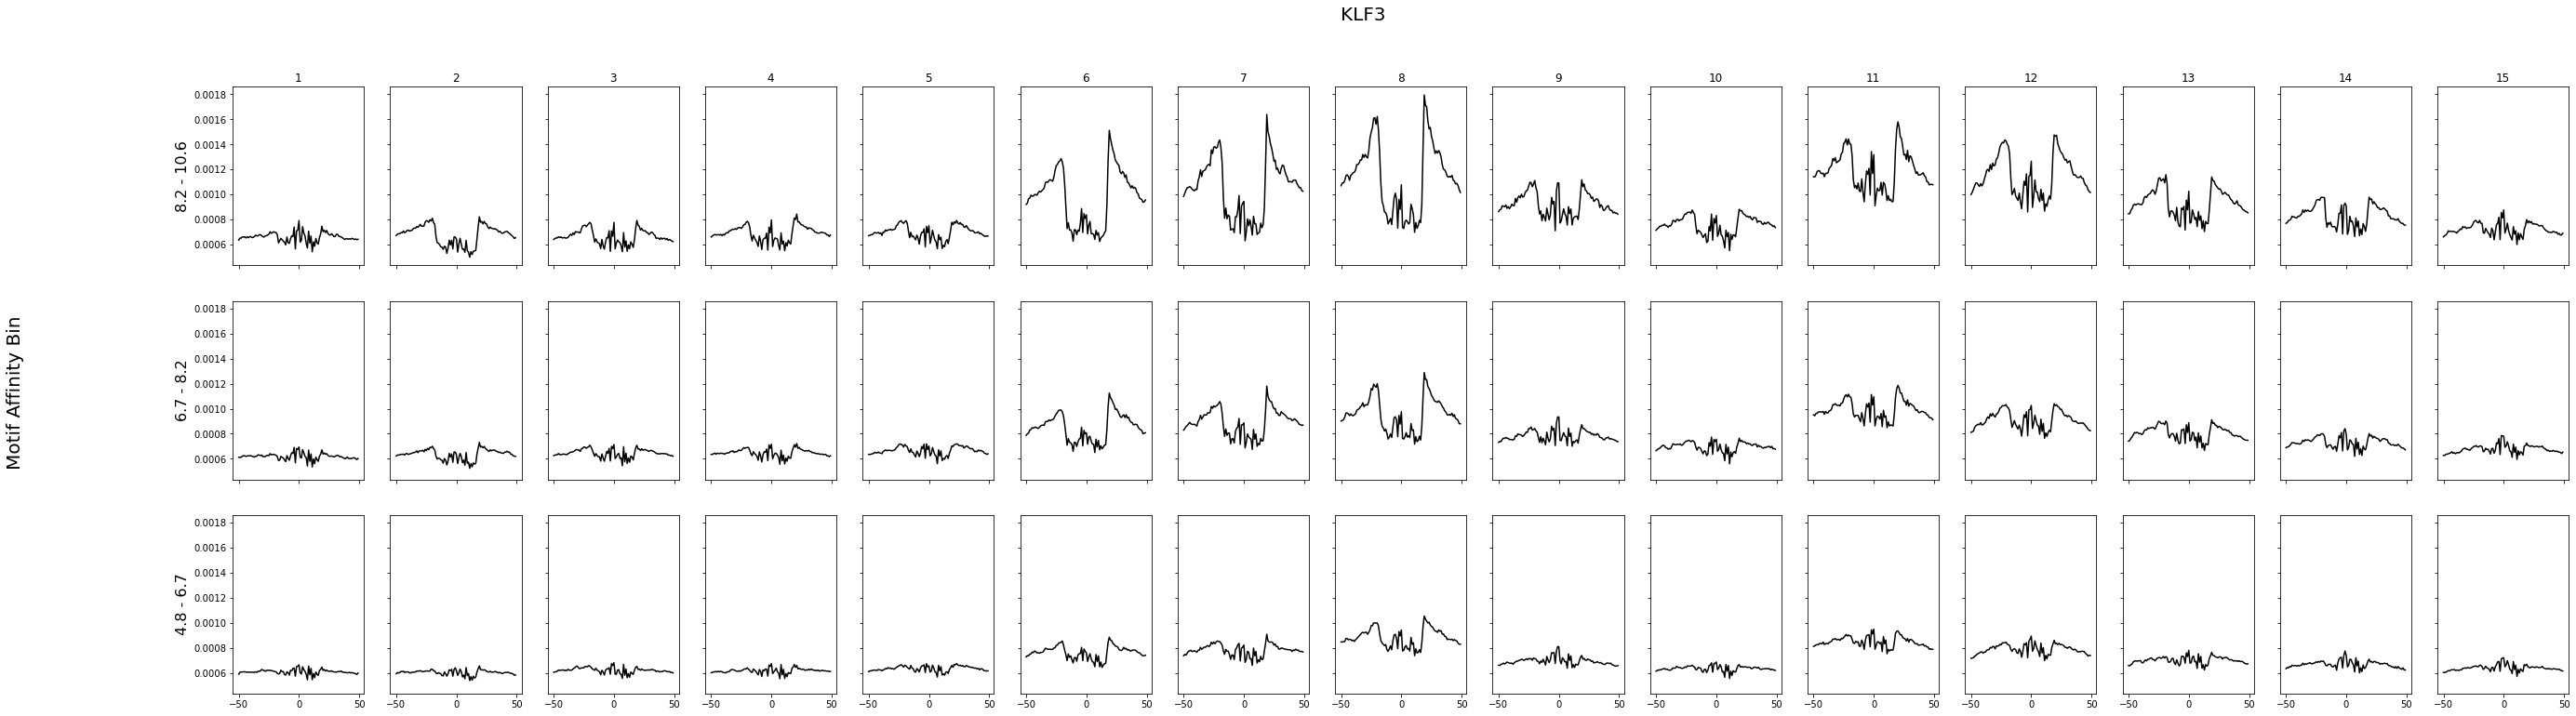

In [54]:
# plot_footprints_grid_old(footprint_data[TF][0], 
#                       footprint_data[TF][1], 
#                      logodds_scores[TF], 
#                      aff_quants3, 
#                      rev_y=True,
#                     add_w_bias=False,
#                     title=TF.split("_")[0])
# # plt.savefig("./subfigs/footprinting/virtual/KLF_q3_wo_bias.pdf")

30

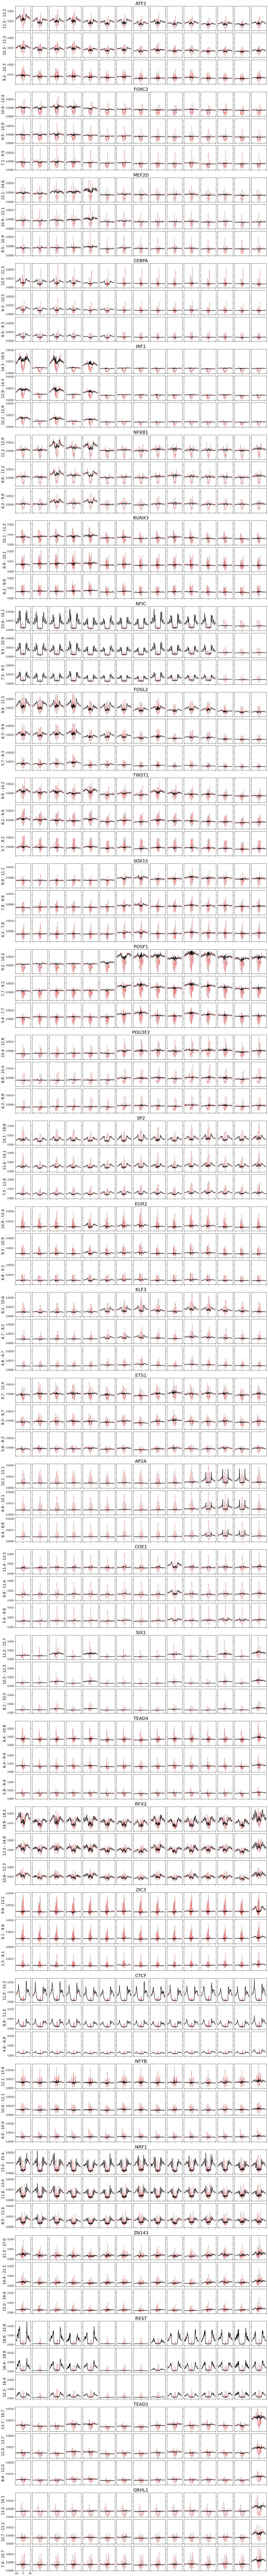

In [153]:
# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
fig = plt.figure(figsize=(20, 7*len(ORDERED)))
outer = gridspec.GridSpec(len(ORDERED), 1, hspace=0.1)

for i in range(len(ORDERED)):
    plot_footprints_grid(footprint_data[ORDERED[i]][0], 
                         footprint_data[ORDERED[i]][1], 
                         logodds_scores[ORDERED[i]], 
                         aff_quants3, 
                         ORDERED[i].split("_")[0],
                         fig,
                         outer[i],
                         show_xlab=(i==len(ORDERED)-1),
                         rev_y=True,
                        add_w_bias=True)
    
# plt.savefig("./Supp/virtual_footprints/plots/q3_w_bias_all.pdf")
fig.show()

<Figure size 432x288 with 0 Axes>

---